In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [2]:
#test camera
# cap = cv2.VideoCapture(0)
# while cap.isOpened():
#     # Read feed
#     _, frame = cap.read()
#     # Show to screenq |
#     cv2.imshow('OpenCV Feed', frame)
#     # Break with
#     if cv2.waitKey(10) & 0xFF == ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()

test key points with MP

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # BGR 2 RGB
    image.flags.writeable = False                  
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # RGB 2 BGR
    return image, results

In [4]:
# def draw_landmarks(image, results):
#     mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
#     mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
#     mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
#     mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [4]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks,  mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=1, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=1, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=1, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=1, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=1, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=1, circle_radius=2)
                             ) 
    
    #mp_holistic.HAND_CONNECTIONS the connections can be none
    #the first one is dot color and the second one is line color

In [5]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        # print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screenq 
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [6]:
draw_styled_landmarks(frame, results)

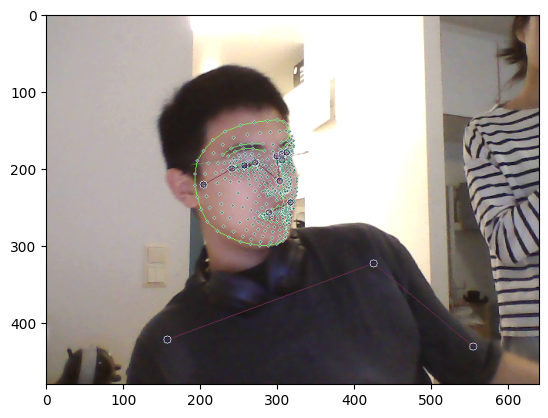

In [7]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

Extract Keypoint Values

In [8]:
result.landmark[20]

AttributeError: 'NoneType' object has no attribute 'landmark'

In [6]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [25]:
result_test = extract_keypoints(results)
result_test

array([ 0.61797011,  0.37762105, -0.4557313 , ...,  0.        ,
        0.        ,  0.        ])

In [26]:
len(result_test)

1662

In [27]:
np.save('0', result_test)

In [28]:
np.load('0.npy')

array([ 0.61797011,  0.37762105, -0.4557313 , ...,  0.        ,
        0.        ,  0.        ])

setup folders for dataset

In [9]:
# Path for numpy arrays data    
DATA_PATH = os.path.join('../MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 30

In [10]:
for action in actions: 
    # dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    for sequence in range(no_sequences):
        os.makedirs(os.path.join(DATA_PATH, action, str(sequence)), exist_ok=True)
        

Collect Keypoint Values for Training and Testing

In [9]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    break_all = False  # Add flag
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        if break_all:  # Check the flag
            break
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            if break_all:  # Check the flagq
                break
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0 : 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    while cv2.waitKey(0) & 0xFF != ord('s'):
                        pass
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break_all = True  # change flag
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


prepare dataset

In [15]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [32]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [17]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [18]:
X=np.array(sequences)
X.shape

(90, 30, 1662)

In [28]:
Y = to_categorical(labels).astype(int)
Y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [33]:
X_train

array([[[ 0.68230474,  0.51240629, -0.74407154, ...,  0.40049779,
          0.63635623, -0.04579584],
        [ 0.68262273,  0.51141876, -0.7337051 , ...,  0.39989144,
          0.62852138, -0.03705185],
        [ 0.68262923,  0.51121575, -0.73635757, ...,  0.39648044,
          0.62916517, -0.03593571],
        ...,
        [ 0.66952336,  0.5141142 , -0.72389996, ...,  0.44329441,
          0.64510709, -0.02355023],
        [ 0.67103684,  0.51436907, -0.66232765, ...,  0.43512765,
          0.65157944, -0.02508167],
        [ 0.67310369,  0.51436019, -0.72226828, ...,  0.42565587,
          0.64958274, -0.02941754]],

       [[ 0.62708473,  0.40298206, -0.89655304, ...,  0.65024954,
          0.8954525 , -0.06041415],
        [ 0.62708461,  0.40282738, -0.91656274, ...,  0.64838713,
          0.90467721, -0.06786463],
        [ 0.62700421,  0.40249231, -0.85743296, ...,  0.65224957,
          0.91266268, -0.06734238],
        ...,
        [ 0.63285577,  0.39783862, -0.94856322, ...,  

Build and Train LSTM Neural Network

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [22]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

2023-10-08 22:46:31.993082: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-10-08 22:46:31.993112: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-10-08 22:46:31.993145: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2023-10-08 22:46:31.993161: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-10-08 22:46:31.993170: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1496] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.


In [34]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))30
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [35]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [25]:
model.fit(X_train, Y_train, epochs=2000, callbacks=[tb_callback])

2023-10-08 22:46:45.728469: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-10-08 22:46:45.730288: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2918400000 Hz


Epoch 1/2000
3/3 [==============================] - 2s 110ms/step - loss: 1.7415 - categorical_accuracy: 0.1918


2023-10-08 22:46:47.064884: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-10-08 22:46:47.064914: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-10-08 22:46:47.064938: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2023-10-08 22:46:47.103859: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-10-08 22:46:47.103978: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1496] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2023-10-08 22:46:47.115839: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2023-10-08 22:46:47.127701: I tensorflow

Epoch 2/2000
3/3 [==============================] - 0s 44ms/step - loss: 1.1042 - categorical_accuracy: 0.3199
Epoch 3/2000
3/3 [==============================] - 0s 44ms/step - loss: 1.5213 - categorical_accuracy: 0.3611
Epoch 4/2000
3/3 [==============================] - 0s 44ms/step - loss: 1.1821 - categorical_accuracy: 0.3728
Epoch 5/2000
3/3 [==============================] - 0s 50ms/step - loss: 1.1046 - categorical_accuracy: 0.3641
Epoch 6/2000
3/3 [==============================] - 0s 54ms/step - loss: 1.1016 - categorical_accuracy: 0.2756
Epoch 7/2000
3/3 [==============================] - 0s 52ms/step - loss: 1.0849 - categorical_accuracy: 0.2808
Epoch 8/2000
3/3 [==============================] - 0s 38ms/step - loss: 1.0917 - categorical_accuracy: 0.2678
Epoch 9/2000
3/3 [==============================] - 0s 48ms/step - loss: 1.0985 - categorical_accuracy: 0.3299
Epoch 10/2000
3/3 [==============================] - 0s 47ms/step - loss: 1.0970 - categorical_accuracy: 0.3563


In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30, 64)            442112    
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 596,675
Trainable params: 596,675
Non-trainable params: 0
________________________________________________

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [12]:
torch.cuda.is_available()

True

In [13]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LSTMNet, self).__init__()
        self.lstm1 = nn.LSTM(input_size, 64, batch_first=True)
        self.lstm2 = nn.LSTM(64, 128, batch_first=True)
        self.lstm3 = nn.LSTM(128, 64, batch_first=True)
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = x[:, -1, :]
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
# 训练数据加载器
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float), torch.tensor(Y_train, dtype=torch.long))
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# 参数
input_size = 1662
num_classes = actions.shape[0]

# 实例化模型
model = LSTMNet(input_size, num_classes)



# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
# 训练模型
num_epochs = 2000
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        outputs = model(inputs)
        loss = criterion(outputs, torch.max(labels, 1)[1])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



In [ ]:
# 检查GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 训练数据加载器
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float), torch.tensor(Y_train, dtype=torch.long))
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# 参数
input_size = 1662
num_classes = actions.shape[0]

# 实例化模型并移动到GPU
model = LSTMNet(input_size, num_classes).to(device)

# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# 训练模型
num_epochs = 2000
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        # 将输入和标签移到GPU
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, torch.max(labels, 1)[1])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()